# Use case 3: retrieving footprints

## Notebook setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from s1etad import Sentinel1Etad

## Open the dataset

In [5]:
filename = "../../sample-products/S1B_IW_ETA__AXDH_20200127T113414_20200127T113858_020002_025D72_0096.SAFE"

In [6]:
eta = Sentinel1Etad(filename)

In [7]:
eta

Sentinel1Etad("../../sample-products/S1B_IW_ETA__AXDH_20200127T113414_20200127T113858_020002_025D72_0096.SAFE")  # 0x7f92b66852d0
Number of Sentinel-1 slices: 11
Sentinel-1 products list:
  S1B_IW_SLC__1ADH_20200127T113414_20200127T113444_020002_025D72_FD42.SAFE
  S1B_IW_SLC__1ADH_20200127T113442_20200127T113510_020002_025D72_FC8F.SAFE
  S1B_IW_SLC__1ADH_20200127T113507_20200127T113534_020002_025D72_78DF.SAFE
  S1B_IW_SLC__1ADH_20200127T113532_20200127T113559_020002_025D72_1ABB.SAFE
  S1B_IW_SLC__1ADH_20200127T113557_20200127T113624_020002_025D72_6706.SAFE
  S1B_IW_SLC__1ADH_20200127T113622_20200127T113649_020002_025D72_78F0.SAFE
  S1B_IW_SLC__1ADH_20200127T113647_20200127T113715_020002_025D72_11FB.SAFE
  S1B_IW_SLC__1ADH_20200127T113712_20200127T113739_020002_025D72_FCC6.SAFE
  S1B_IW_SLC__1ADH_20200127T113737_20200127T113804_020002_025D72_1FED.SAFE
  S1B_IW_SLC__1ADH_20200127T113802_20200127T113829_020002_025D72_C434.SAFE
  S1B_IW_SLC__1ADH_20200127T113827_20200127T113858_020002_025D

## Helpers

In [8]:
import cartopy.crs as ccrs
from matplotlib import patches as mpatches
from shapely.geometry import MultiPolygon


def tile_extent(poly, margin=2):
    bounding_box = list(poly.bounds)
    bounding_box[1:3] = bounding_box[2:0:-1]
    return np.asarray(bounding_box) + [-margin, margin, -margin, margin]

## Select bursts

In [9]:
import dateutil

first_time = dateutil.parser.parse("2020-01-27T11:38:31.921690")
selection = eta.query_burst(first_time=first_time)

## Get footprints of the selected bursts

In [10]:
polys = eta.get_footprint(selection=selection)

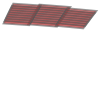

In [11]:
polys

## Plot footprints

/Users/valentino/anaconda3/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  from ipykernel import kernelapp as app


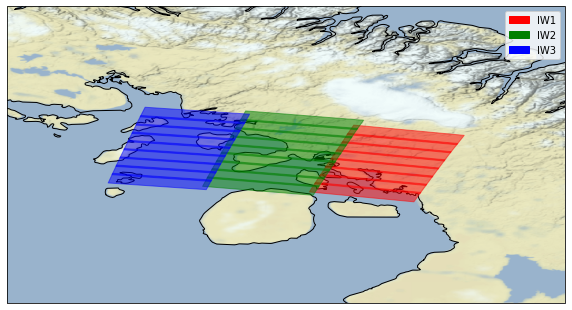

In [12]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(tile_extent(MultiPolygon(polys)))

# Put a background image on for nice sea rendering.
OFFLINE = False
if OFFLINE:
    import cartopy.feature as cfeature

    ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
else:
    import cartopy.io.img_tiles as cimgt

    # stamen_terrain = cimgt.Stamen('terrain-background')  # need cartopy >= 0.18
    stamen_terrain = cimgt.StamenTerrain()
    ax.add_image(stamen_terrain, 6)  # up to 10
    ax.coastlines()

# plot footprints of all selected burst
# ax.add_geometries(polys, crs=ccrs.PlateCarree(), alpha=0.8)

# get the footprints of each swath and plot them with different colors
items = []
for swath, color in zip(eta, ["red", "green", "blue"]):
    polys = swath.get_footprint(selection=selection)
    item = ax.add_geometries(
        polys, crs=ccrs.PlateCarree(), alpha=0.5, color=color
    )
    items.append(item)

handles = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(["red", "green", "blue"], eta.swath_list)
]
plt.legend(handles=handles)